In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive"

'Colab Notebooks'   Lung      Skin		  Tst
 FinalSkin	    Pose     'Training Batch 1'   Videos
 Iris		    Project  'Training Batch 2'


In [3]:
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import model_from_json

import keras.backend as K
import tensorflow as tf
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle
import os
from nibabel.testing import data_path
import zipfile
import io


Datapath='/content/drive/My Drive/Training Batch 1'

print(Datapath)

imgdata=[]

img_path = sorted(glob(Datapath+"/volume-*.nii"))
mask_path = sorted(glob(Datapath+"/segmentation-*.nii"))

print(img_path)
print("Number of images :", len(img_path))


patch_ratio = []

for i in range(6+ 1):
  patch_ratio.append(32 * i)

print(patch_ratio)
#

/content/drive/My Drive/Training Batch 1
['/content/drive/My Drive/Training Batch 1/volume-0.nii', '/content/drive/My Drive/Training Batch 1/volume-1.nii', '/content/drive/My Drive/Training Batch 1/volume-10.nii', '/content/drive/My Drive/Training Batch 1/volume-11.nii', '/content/drive/My Drive/Training Batch 1/volume-12.nii', '/content/drive/My Drive/Training Batch 1/volume-13.nii', '/content/drive/My Drive/Training Batch 1/volume-14.nii', '/content/drive/My Drive/Training Batch 1/volume-15.nii', '/content/drive/My Drive/Training Batch 1/volume-16.nii', '/content/drive/My Drive/Training Batch 1/volume-17.nii', '/content/drive/My Drive/Training Batch 1/volume-18.nii', '/content/drive/My Drive/Training Batch 1/volume-19.nii', '/content/drive/My Drive/Training Batch 1/volume-2.nii', '/content/drive/My Drive/Training Batch 1/volume-20.nii', '/content/drive/My Drive/Training Batch 1/volume-21.nii', '/content/drive/My Drive/Training Batch 1/volume-22.nii', '/content/drive/My Drive/Training

In [4]:
def patch_sampling(img, mask, patch_ratio, pos_neg_ratio, threshold):
  
  temp_mask = mask
  
  temp_mask[temp_mask == 1] = 0
  temp_mask[temp_mask == 2] = 1
  
  positive_patch = []
  positive_mask = []
  
  negative_patch = []
  negative_mask = []
  
  negative_set = []
  
  
  for i in range(temp_mask.shape[2]):
    for x_bin in range(2, len(patch_ratio)):
        for y_bin in range(2, len(patch_ratio)):
          img_patch = img[patch_ratio[x_bin-2] : patch_ratio[x_bin], patch_ratio[y_bin - 2] : patch_ratio[y_bin], i]
          mask_patch = temp_mask[patch_ratio[x_bin-2] : patch_ratio[x_bin], patch_ratio[y_bin - 2] : patch_ratio[y_bin], i]
          _, count = np.unique(mask_patch, return_counts = True)
          
          if len(count) == 2:
            mask_percentage = count[1] / sum(count) * 100
          
            if threshold < mask_percentage :
              positive_patch.append(img_patch)
              positive_mask.append(mask_patch)
          
          
          elif len(count) ==1:
            
            temp_list = []
            temp_list.append(img_patch)
            temp_list.append(mask_patch)
            
            negative_set.append(temp_list)
  
  shuffle(negative_set)
  
  negative_set_to_use = negative_set[:len(positive_patch) * pos_neg_ratio]
  for negative_set in negative_set_to_use:
    negative_patch.append(negative_set[0])
    negative_mask.append(negative_set[1])
  
  negative_set_to_use = []
  
  return positive_patch, positive_mask, negative_patch, negative_mask
def slice_to_patch(slice, patch_ratio):
  
  slice[slice == 1] = 0
  slice[slice == 2] = 1
  
  patch_list = []
  
  for x_bin in range(2, len(patch_ratio)):
    for y_bin in range(2, len(patch_ratio)):
      patch = slice[patch_ratio[x_bin-2] : patch_ratio[x_bin], patch_ratio[y_bin - 2] : patch_ratio[y_bin]]
      patch = patch.reshape(patch.shape + (1,))
      patch_list.append(patch)
  
  return np.array(patch_list)

def patch_to_slice(patch, patch_ratio, input_shape, conf_threshold):
    
  slice = np.zeros((512, 512, 1))
  row_idx = 0
  col_idx = 0
  
  for i in range(len(patch)):
    
    slice[patch_ratio[row_idx]:patch_ratio[row_idx + 2], patch_ratio[col_idx]:patch_ratio[col_idx + 2]][patch[i] > conf_threshold] = 1
    
    col_idx += 1
    
    if i != 0 and (i+1) % 5 == 0:
      row_idx += 1
      col_idx = 0
  
  return slice

 

In [5]:


def dsc(y_true, y_pred):
    
  smooth = 1.
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  score=(2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  return score

def dice_loss(y_true, y_pred):
  '''
  y_pred=tf.cast(y_pred, tf.float32)
  print('2')
  loss = 1 - dsc(y_true, y_pred)
  return loss  
  '''


  y_true=tf.cast(y_true, tf.float32)
  y_pred=tf.cast(y_pred, tf.float32)
  y_pred = tf.clip_by_value(y_pred, 10e-8, 1.-10e-8)
  loss = - (y_true * K.log(y_pred) * 0.90 + (1 - y_true) * K.log(1 - y_pred) * 0.10)
    
  return K.mean(loss)
    

def iou(y_true, y_pred):

  smooth = 1.
  intersection = K.sum(y_true * y_pred)
  print('3')
  sum1 = K.sum(y_true + y_pred)
  print(intersection,sum1)
  iou = (intersection + smooth) / (sum1 - intersection + smooth)
  return iou


def mTPR(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)   
    recall = true_positives / (possible_positives + K.epsilon())    
    balanced_recall = K.mean(recall)    
    return balanced_recall

    
def MER(y_true, y_pred):
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))

    ER=(fp+fn)/(fp+fn+tp+tn)
    MER=K.mean(ER)
    return MER

def plot(train,test,title, metric):
  plt.plot(train)
  plt.plot(test)
  plt.title(title)
  plt.ylabel(metric)
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()



In [6]:
inputs = Input(shape=[64, 64,1])
m=64
n=64

def bn_act(x, act=True):
    x = BatchNormalization()(x)
    if act == True:
        x = Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    c = Concatenate()([u, xskip])
    return c

def ResUnet():
    
    f = [16, 32, 64, 128, 256]
    inputs = Input((m, m, 1))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = Conv2D(filters = 1, kernel_size = 1, activation="sigmoid")(d4)
       
    model = Model( inputs,  outputs)    
    
    model.summary()
    return model



In [7]:
def load_data():
  
  total_data = 0
  total_patch = []
  total_mask = []
  print(len(img_path))
  for i in range(len(img_path) - 2):
    print(i)    
    img_3D = nib.load(img_path[i]).get_data()
    mask_3D = nib.load(mask_path[i]).get_data()
    
    pos_patch, pos_mask, neg_patch, neg_mask = patch_sampling(img_3D, mask_3D, patch_ratio, 3, 3.0)
    total_patch += (pos_patch + neg_patch)
    total_mask += (pos_mask + neg_mask)

    print("======= Step [{0} / {1}] : # of patches = {2} | # of total training images = {3} =======".
          format(format(i+1, '>2'), len(img_path), format(len(pos_patch) + len(neg_patch), '>5'), format(len(total_patch), '>5')))

  total_patch = np.array(total_patch).reshape((len(total_patch), m, n, 1))
  total_mask = np.array(total_mask).reshape((len(total_mask), m, n, 1))
  np.save("total_patch.npy", total_patch)
  np.save("total_mask.npy", total_mask)

  image_train, image_test, mask_train, mask_test = train_test_split(total_patch,
                                                        total_mask,
                                                        test_size=0.1,shuffle=True, random_state = 42)
  
  np.save("image_train.npy", image_train)
  np.save("image_test.npy", image_test)
  np.save("mask_train.npy", mask_train)
  np.save("mask_test.npy", mask_test)
  print(image_train.shape, image_test.shape, mask_train.shape, mask_test.shape)
  return image_train, image_test, mask_train, mask_test


#load_data()



In [8]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from statistics import mean
import sklearn
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

def train_ResUnet():
    print('start')    

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model=ResUnet()
    print('333')
    image_train, image_test, mask_train, mask_test = load_data()
    print('6666')
    
    opt = Adam(lr = 1e-4)
    
    #model.compile(optimizer = opt, loss = weighted_binary_crossentropy, metrics = [dice_coef])
    #model.fit(image_train, mask_train, batch_size = 512, epochs = 40)
  
    model.compile(optimizer = opt, loss = dice_loss, metrics = [dsc,
                                                                iou,
                                                                'acc',
                                                                mTPR,
                                                                MER

                                                                ])

    
    checkpointer = ModelCheckpoint(filepath="/content/ResUnet_Liver.hdf5", 
                                   verbose=1, 
                                   save_best_only=True
                                  )
    earlystopping = EarlyStopping(monitor='val_loss',
                                  mode='auto', 
                                  verbose=1, 
                                  patience=15
                                 )
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  mode='auto',
                                  verbose=1,
                                  patience=10,
                                  min_delta=0.0001,
                                  factor=0.2
                                 )

    

    print('Fitting model...')
    history = model.fit(image_train, mask_train,batch_size = 16, epochs=100, verbose=2,
                        validation_data=(image_test, mask_test),
                        callbacks=[checkpointer,  reduce_lr])

    print("Accuracy is:",mean(history.history['acc']))
    print("Val Accuracy is:",mean(history.history['val_acc']))
    print("Loss is:",mean(history.history['loss']))
    print("Val Loss is:",mean(history.history['val_loss']))
    print("Dsc is:",mean(history.history['dsc']))
    print("Val Dsc is:",mean(history.history['val_dsc']))
    print("iou is:",mean(history.history['iou']))
    print("VAl iou is:",mean(history.history['val_iou']))
    print("mTPR is:",mean(history.history['mTPR']))
    print("MER is:",mean(history.history['MER']))

    a = history.history
    plot(a['dsc'],a['val_dsc'],"Dice_coeff vs Epoch", "Dice_coeff")
    plot(a['iou'],a['val_iou'],"IOU vs Epoch", "iou")
    plot(a['acc'],a['val_acc'],"Accuracy vs Epoch", "Accuracy")
    plot(a['loss'],a['val_loss'],"Loss vs Epoch", "Loss")

    #show(model,image_test,mask_test)
   

start
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   160         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 64, 64, 16)   0           ['batch_normalization[0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [ 1 / 28] : # of patches =    20 | # of total training images =    20 =======
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [ 2 / 28] : # of patches =     8 | # of total training images =    28 =======
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [ 3 / 28] : # of patches =     0 | # of total training images =    28 =======
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [ 4 / 28] : # of patches =     0 | # of total training images =    28 =======
4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [ 5 / 28] : # of patches =     0 | # of total training images =    28 =======
5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [ 6 / 28] : # of patches =   292 | # of total training images =   320 =======
6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [ 7 / 28] : # of patches =     0 | # of total training images =   320 =======
7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [ 8 / 28] : # of patches =     0 | # of total training images =   320 =======
8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [ 9 / 28] : # of patches =  1612 | # of total training images =  1932 =======
9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [10 / 28] : # of patches =   136 | # of total training images =  2068 =======
10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [11 / 28] : # of patches =     0 | # of total training images =  2068 =======
11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [12 / 28] : # of patches =     0 | # of total training images =  2068 =======
12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [13 / 28] : # of patches =     0 | # of total training images =  2068 =======
13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [14 / 28] : # of patches =     0 | # of total training images =  2068 =======
14


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [15 / 28] : # of patches =     0 | # of total training images =  2068 =======
15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [16 / 28] : # of patches =     0 | # of total training images =  2068 =======
16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [17 / 28] : # of patches =     0 | # of total training images =  2068 =======
17


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [18 / 28] : # of patches =     0 | # of total training images =  2068 =======
18


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [19 / 28] : # of patches =     0 | # of total training images =  2068 =======
19


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [20 / 28] : # of patches =     0 | # of total training images =  2068 =======
20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [21 / 28] : # of patches =     0 | # of total training images =  2068 =======
21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [22 / 28] : # of patches =     0 | # of total training images =  2068 =======
22


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [23 / 28] : # of patches =  1524 | # of total training images =  3592 =======
23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [24 / 28] : # of patches =     0 | # of total training images =  3592 =======
24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [25 / 28] : # of patches =     0 | # of total training images =  3592 =======
25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


======= Step [26 / 28] : # of patches =   216 | # of total training images =  3808 =======
(3427, 64, 64, 1) (381, 64, 64, 1) (3427, 64, 64, 1) (381, 64, 64, 1)
6666


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Fitting model...
Epoch 1/100
3
Tensor("Sum_6:0", shape=(), dtype=float32) Tensor("Sum_7:0", shape=(), dtype=float32)
3
Tensor("Sum_6:0", shape=(), dtype=float32) Tensor("Sum_7:0", shape=(), dtype=float32)
3
Tensor("Sum_6:0", shape=(), dtype=float32) Tensor("Sum_7:0", shape=(), dtype=float32)

Epoch 00001: val_loss improved from inf to 0.02793, saving model to /content/ResUnet_Liver.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


215/215 - 46s - loss: 0.0301 - dsc: 0.3520 - iou: 0.2300 - acc: 0.9078 - mTPR: 0.3908 - MER: 0.0956 - val_loss: 0.0279 - val_dsc: 0.3541 - val_iou: 0.2250 - val_acc: 0.9724 - val_mTPR: 0.2350 - val_MER: 0.0283 - lr: 1.0000e-04 - 46s/epoch - 212ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 0.02793 to 0.01043, saving model to /content/ResUnet_Liver.hdf5
215/215 - 18s - loss: 0.0136 - dsc: 0.5524 - iou: 0.4077 - acc: 0.9663 - mTPR: 0.4069 - MER: 0.0349 - val_loss: 0.0104 - val_dsc: 0.4978 - val_iou: 0.3476 - val_acc: 0.9639 - val_mTPR: 0.3754 - val_MER: 0.0376 - lr: 1.0000e-04 - 18s/epoch - 84ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 0.01043 to 0.00630, saving model to /content/ResUnet_Liver.hdf5
215/215 - 18s - loss: 0.0088 - dsc: 0.6785 - iou: 0.5371 - acc: 0.9796 - mTPR: 0.4263 - MER: 0.0214 - val_loss: 0.0063 - val_dsc: 0.6629 - val_iou: 0.5076 - val_acc: 0.9801 - val_mTPR: 0.3776 - val_MER: 0.0208 - lr: 1.0000e-04 - 18s/epoch - 84ms/step
Epoch 4/100

Epoch 0

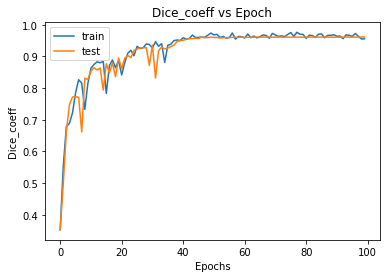

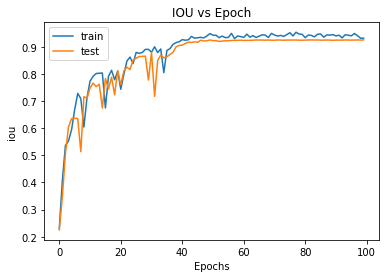

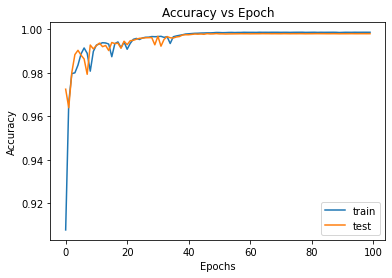

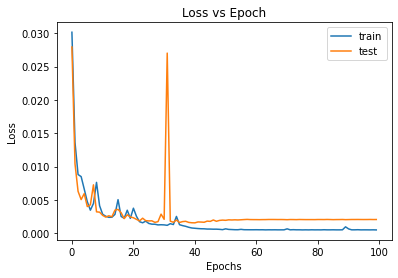

In [9]:
train_ResUnet()

# **Predictaion**

/content/drive/My Drive/Training Batch 2
Loaded model from disk


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


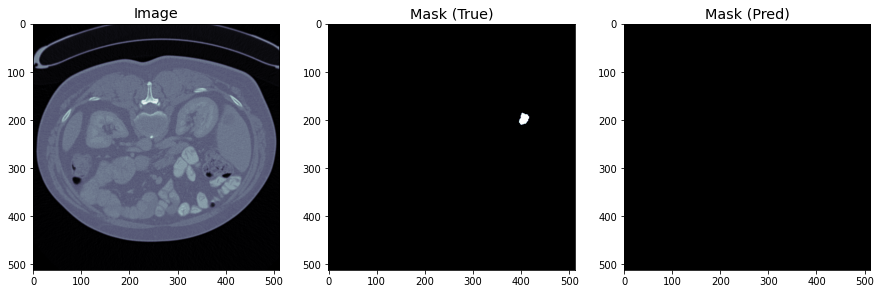

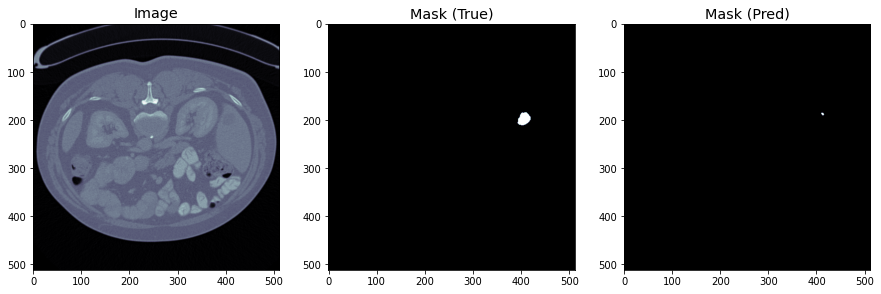

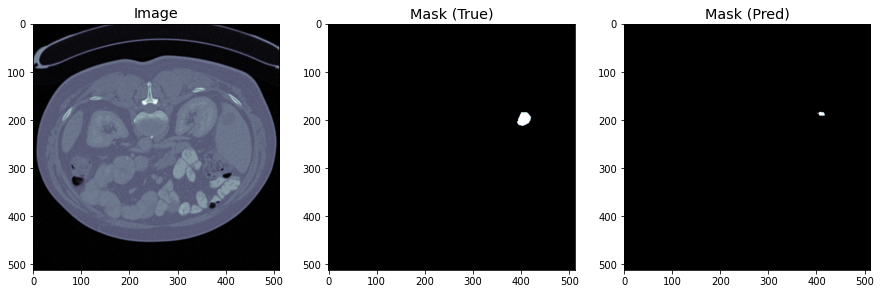

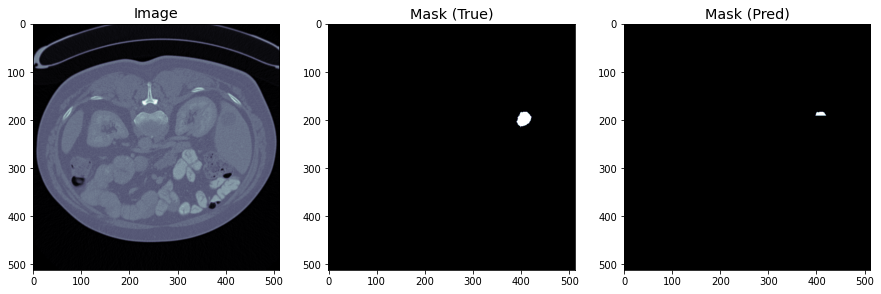

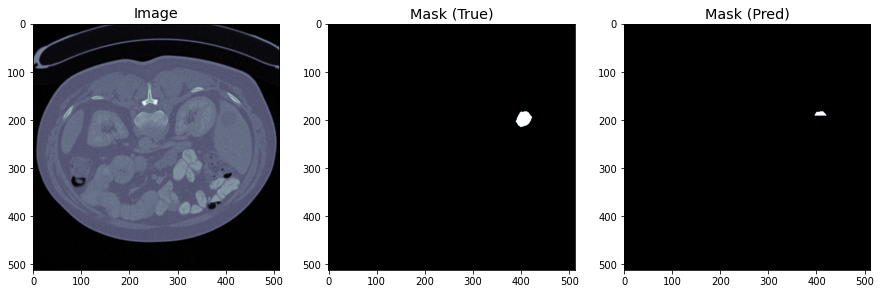

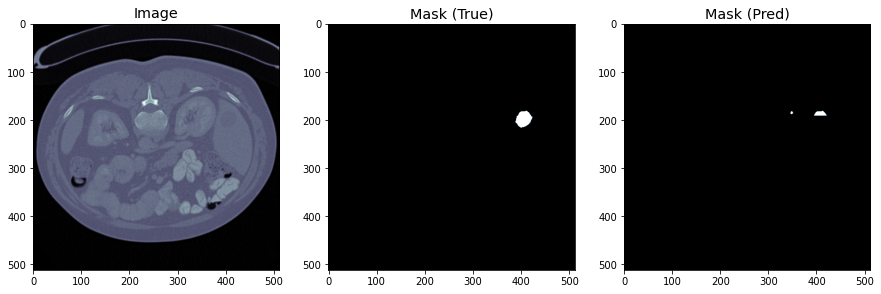

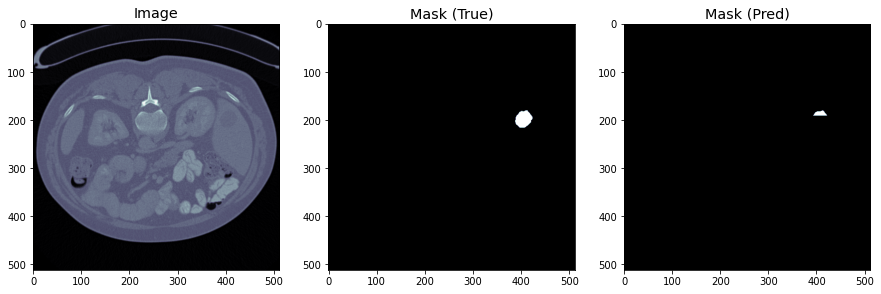

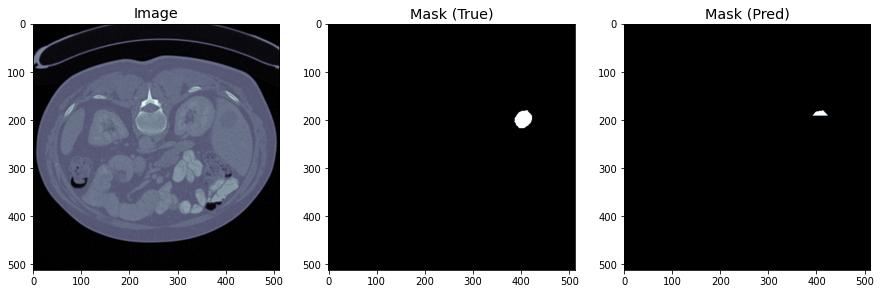

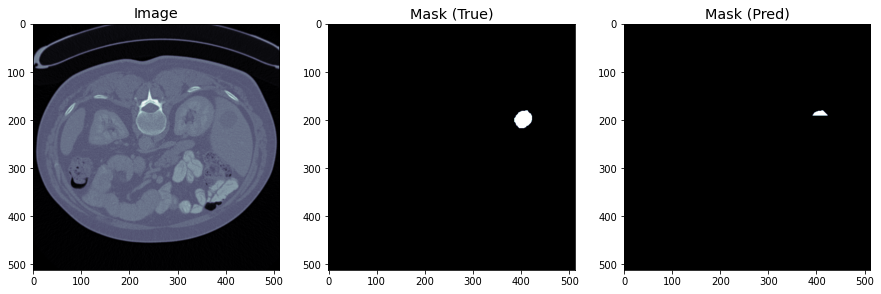

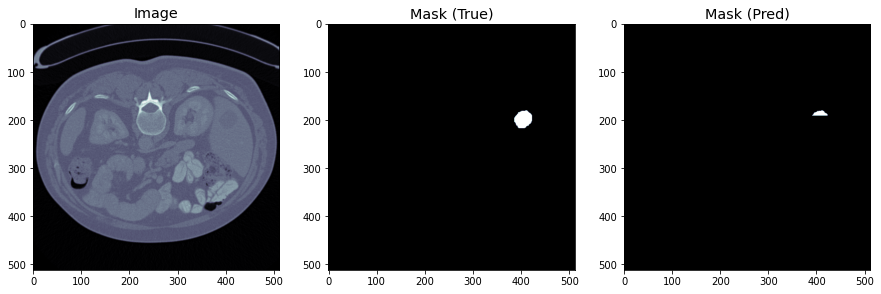

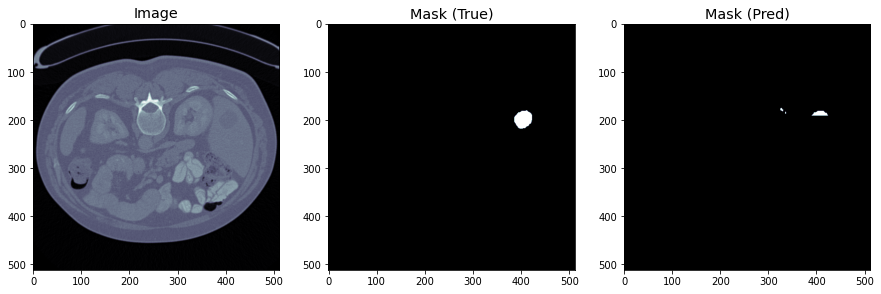

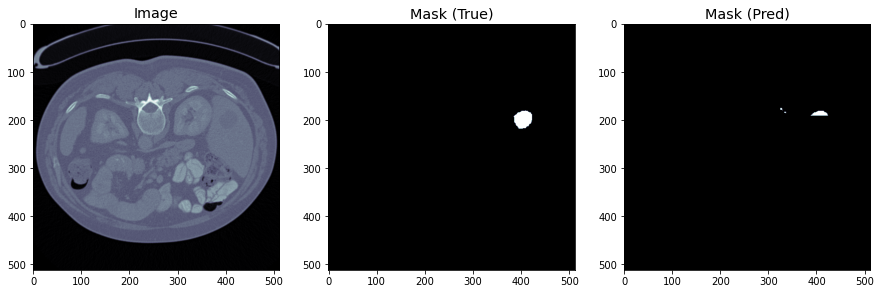

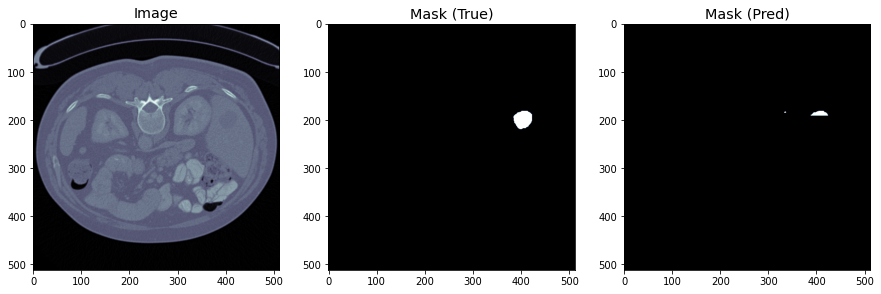

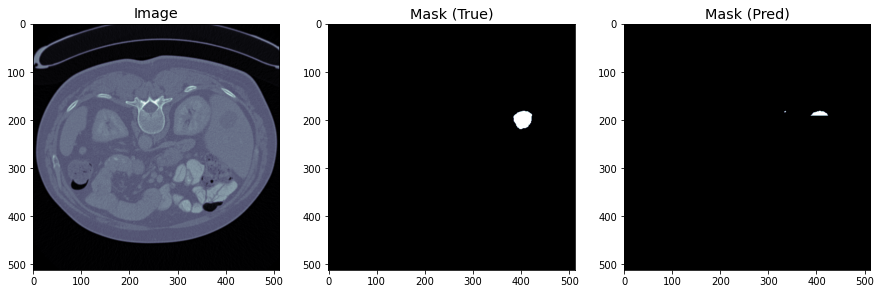

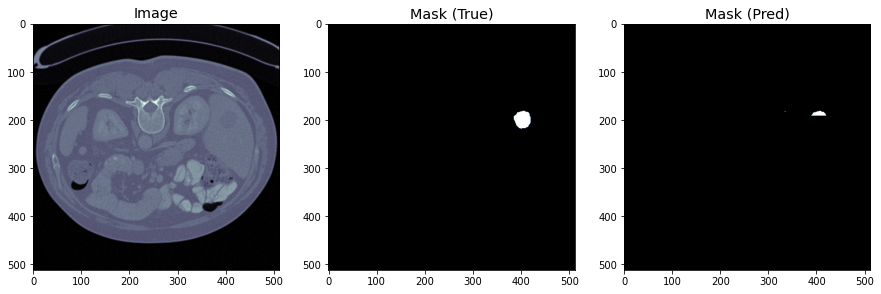

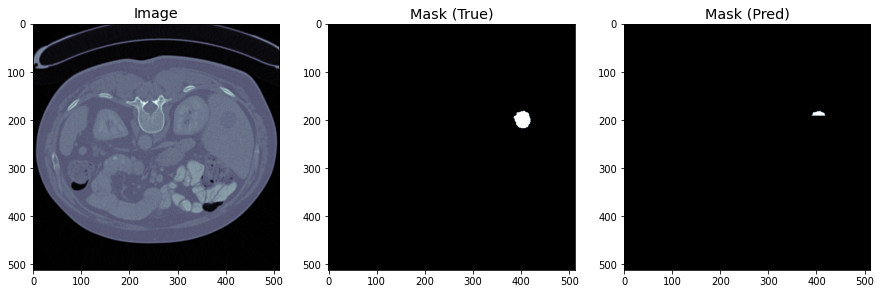

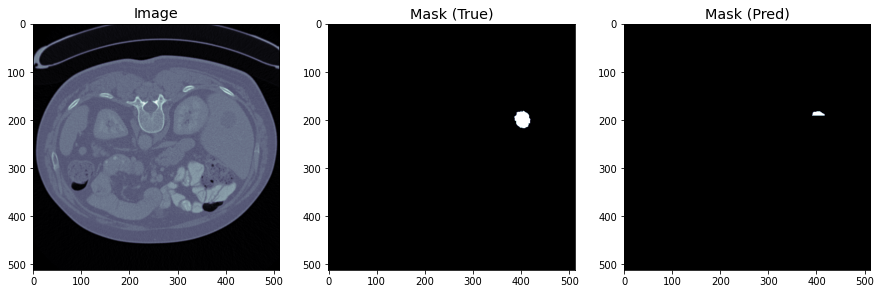

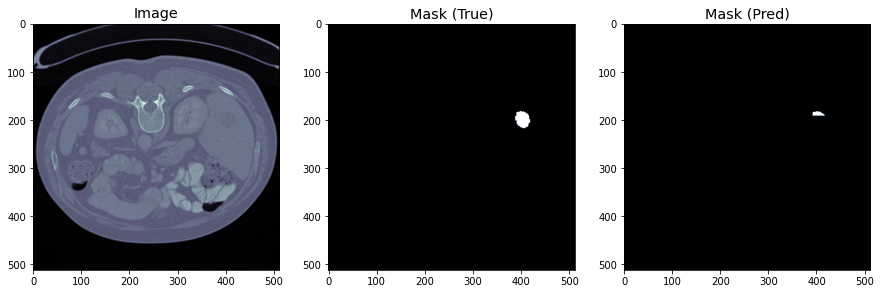

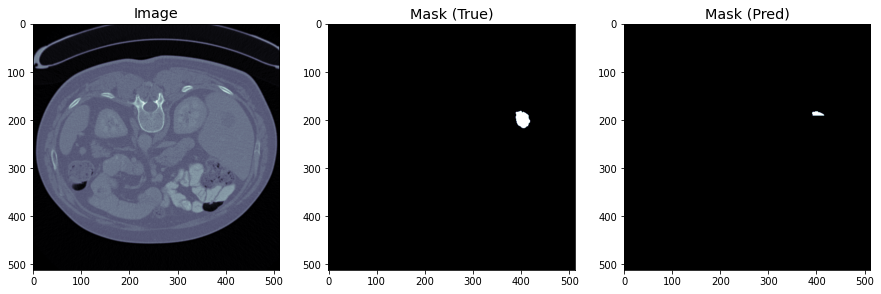

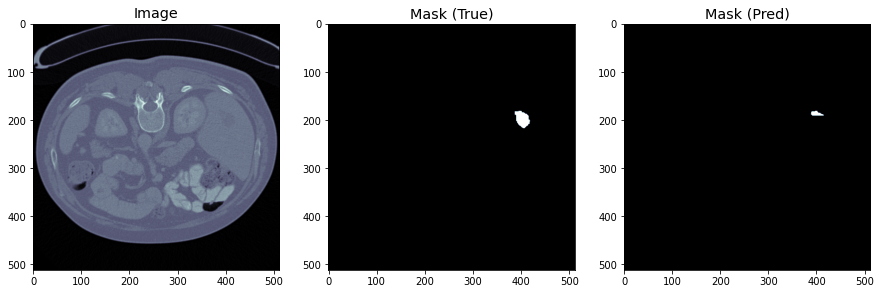

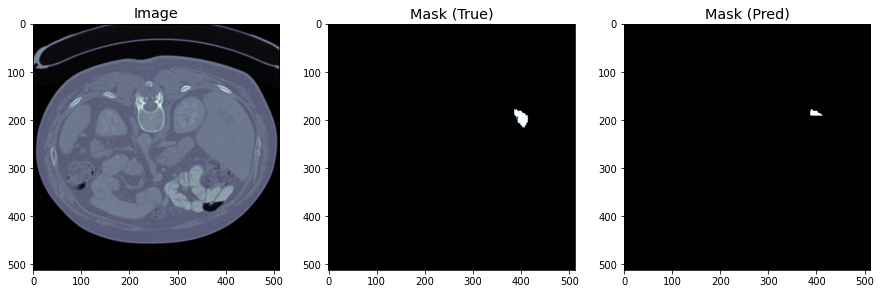

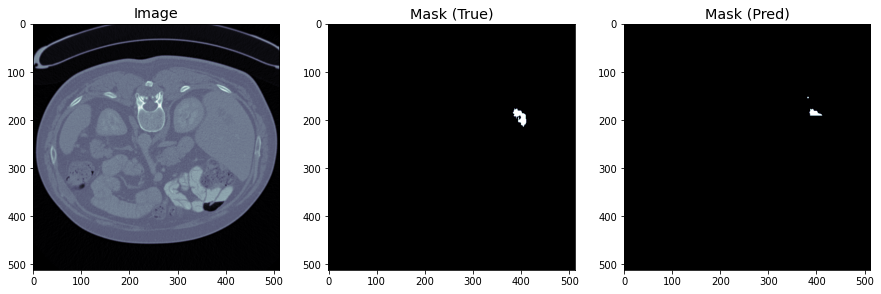

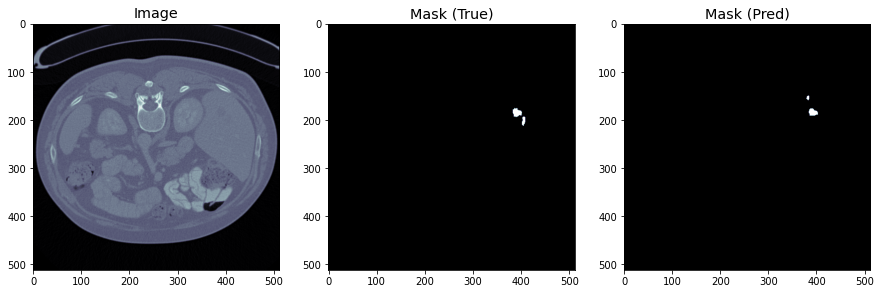

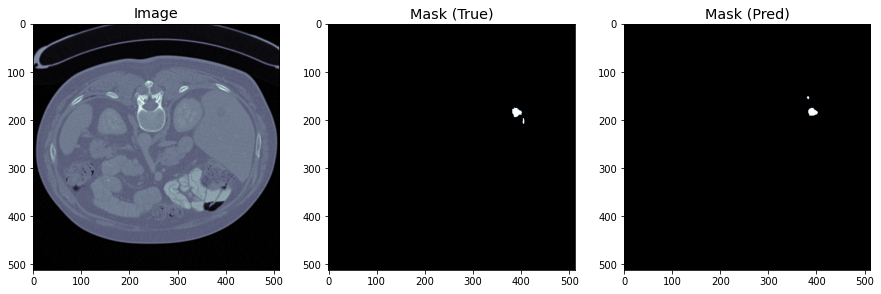

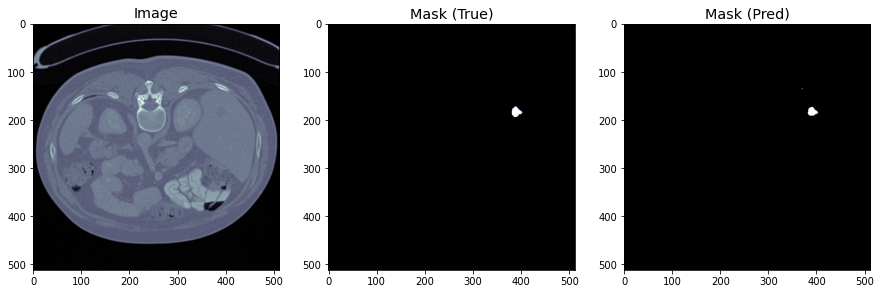

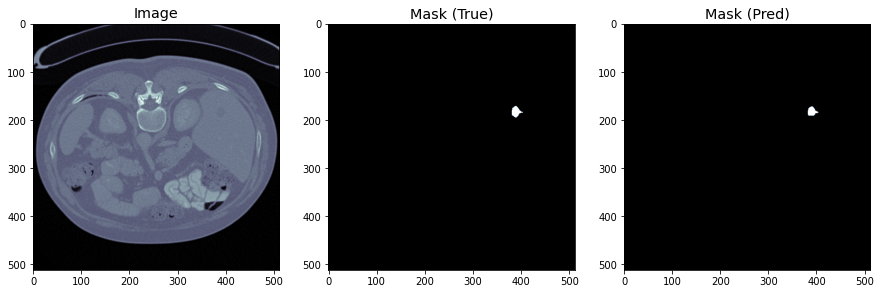

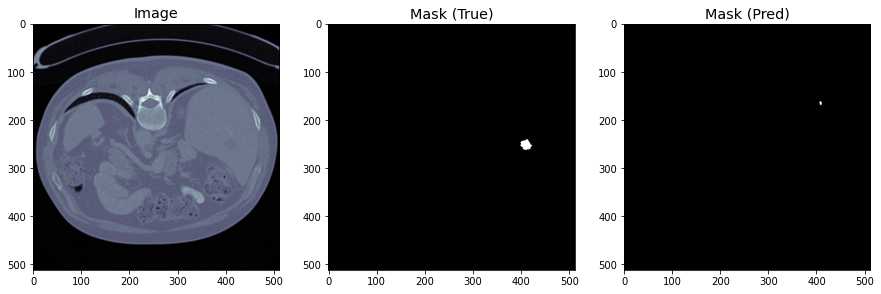

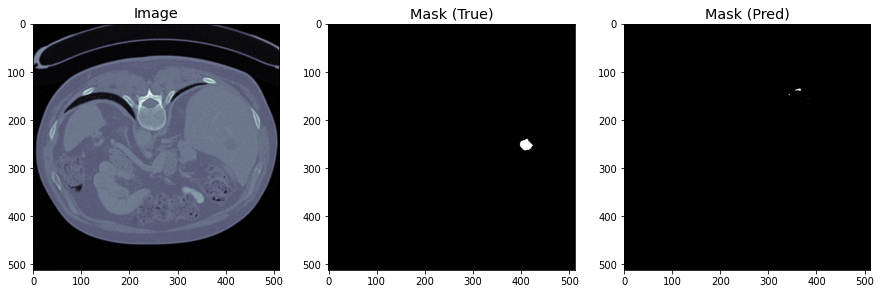

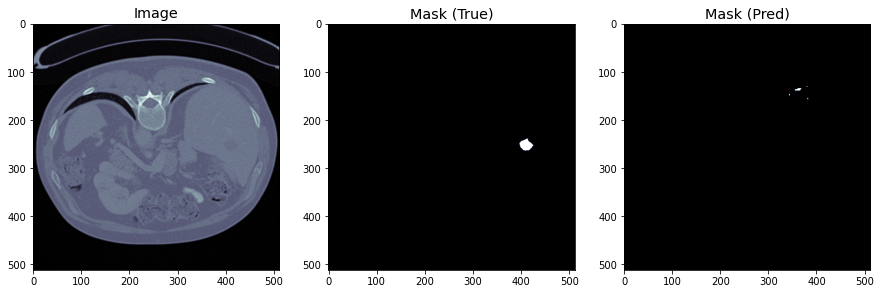

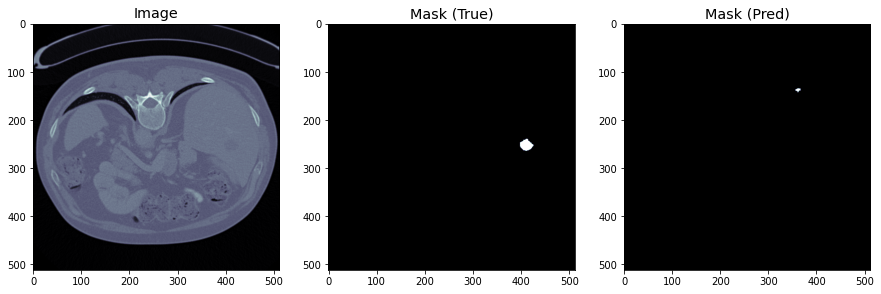

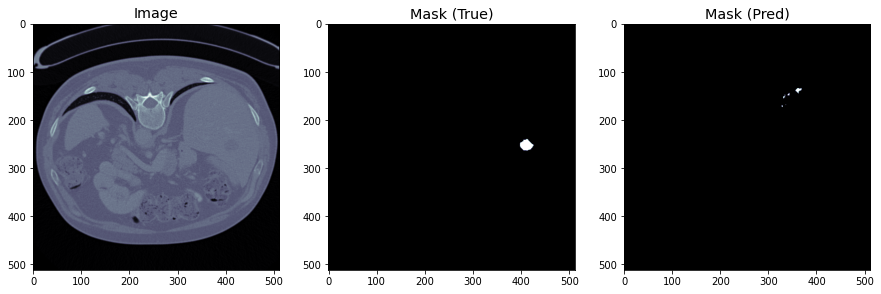

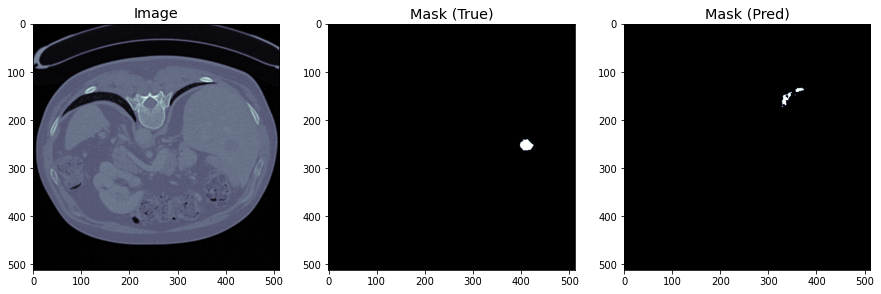

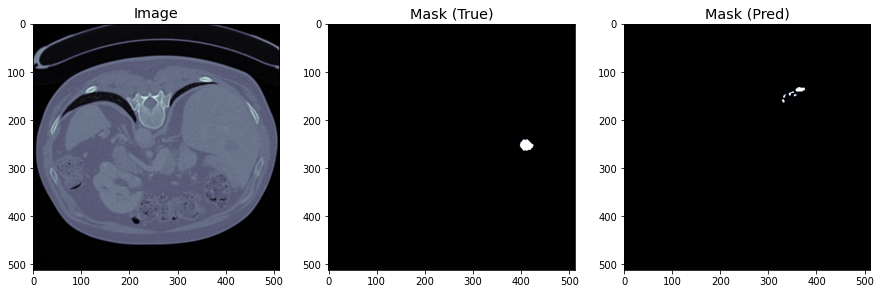

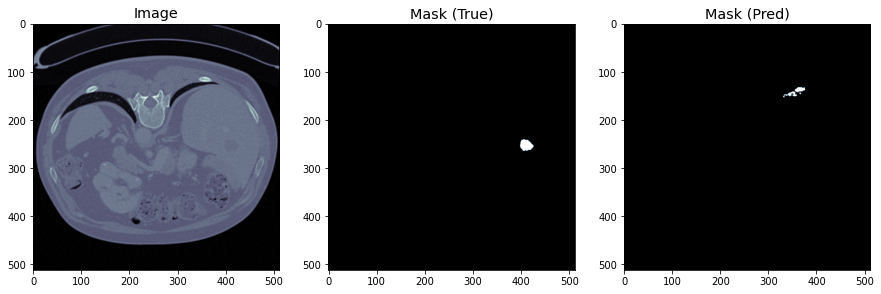

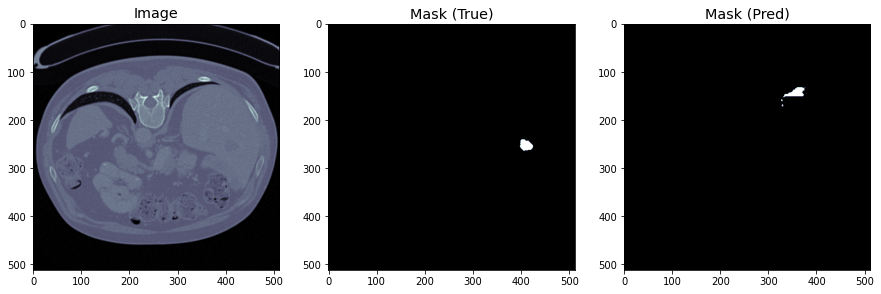

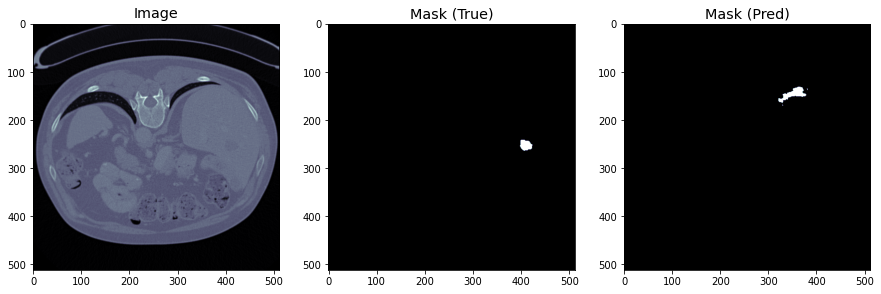

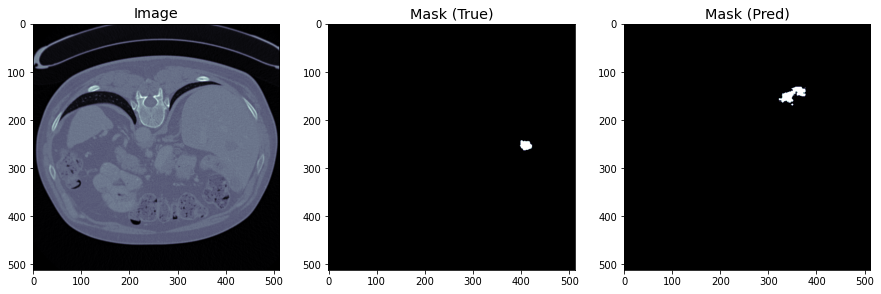

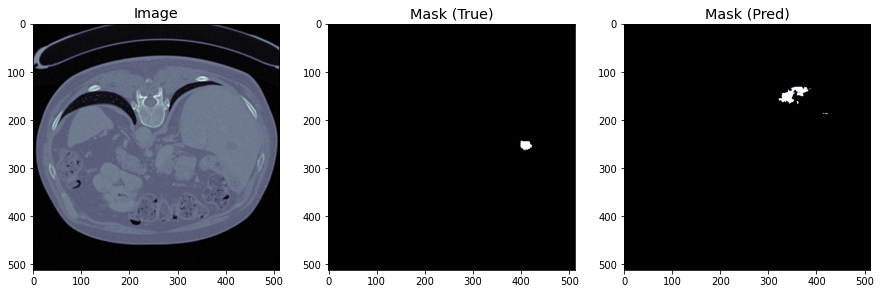

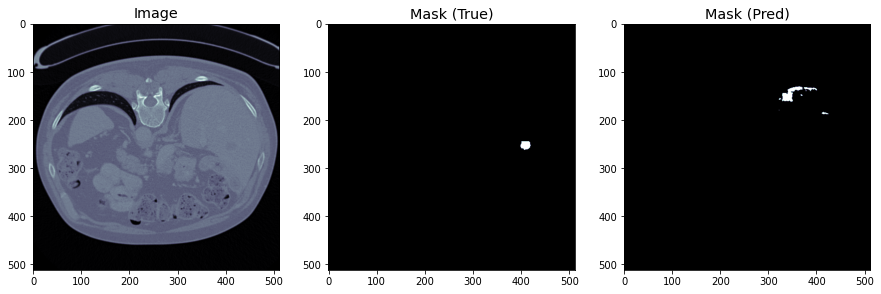

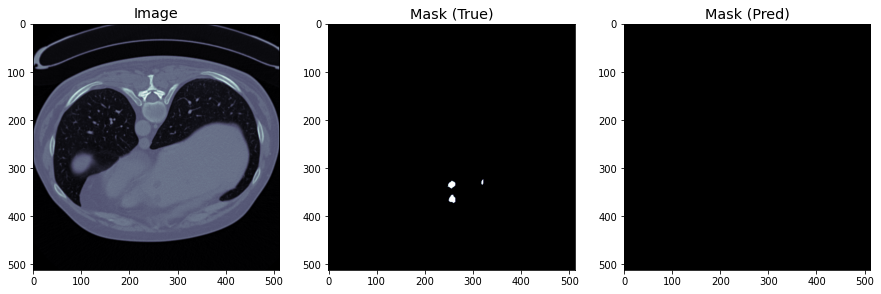

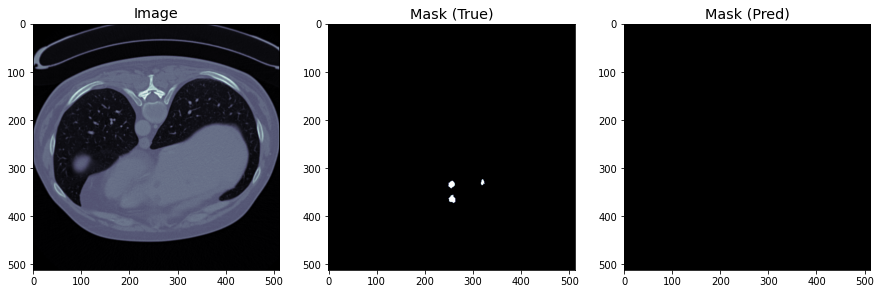

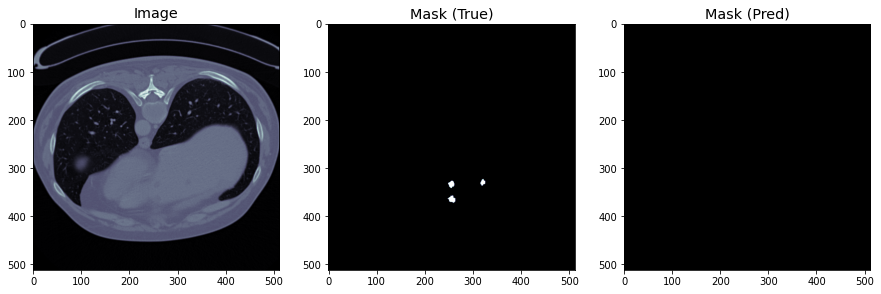

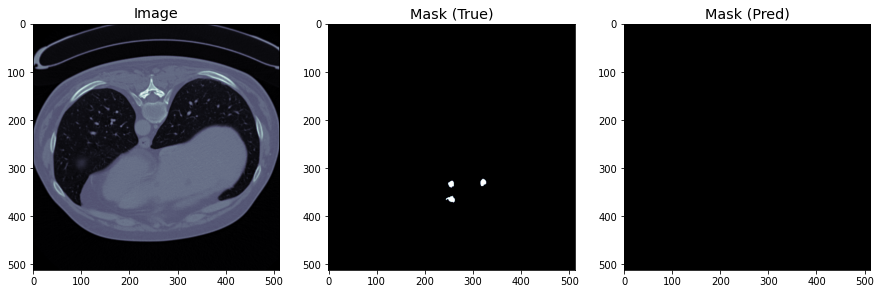

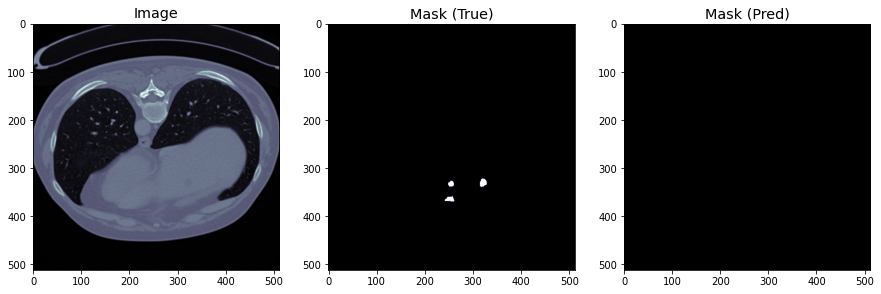

In [10]:
import keras
from keras.models import load_model
model = keras.models.Sequential() 
input_shape = [64, 64, 1]

Datapath='/content/drive/My Drive/Training Batch 2'

print(Datapath)

imgdata=[]

img_path2 = sorted(glob(Datapath+"/volume-*.nii"))
mask_path2 = sorted(glob(Datapath+"/segmentation-*.nii"))


from keras.models import load_model 

loaded_model = load_model("/content/ResUnet_Liver.hdf5", compile=False)
print("Loaded model from disk")

img_ex = nib.load(img_path[25]).get_data()
mask_ex = nib.load(mask_path[25]).get_data()

mask_ex[mask_ex == 1] = 0


for i in range(mask_ex.shape[2]):
    _, count = np.unique(mask_ex[:, :, i], return_counts=True)
    
    if len(count) > 1 and count[1] > 300:
        
        patch_ex = slice_to_patch(img_ex[:, :, i], patch_ratio)
        prediction = loaded_model.predict(patch_ex)
        prediction_mask = patch_to_slice(prediction, patch_ratio, input_shape, conf_threshold = 0.97)
        
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize = ((15, 15)))
        
        ax1.imshow(np.rot90(img_ex[:, :, i], 3), cmap = 'bone')
        ax1.set_title("Image", fontsize = "x-large")
        ax1.grid(False)
        ax2.imshow(np.rot90(mask_ex[:, :, i], 3), cmap = 'bone')
        ax2.set_title("Mask (True)", fontsize = "x-large")
        ax2.grid(False)
        ax3.imshow(np.rot90(prediction_mask.reshape((512, 512)), 3), cmap = 'bone')
        ax3.set_title("Mask (Pred)", fontsize = "x-large")
        ax3.grid(False)
        plt.show()